In [1]:
# Authors:
# Jackson Hoffart <jackson dot hoffart at gmail dot com>

# License: GPL-3.0

# include this when deploying!
# ! pip freeze > requirements.txt

''' import some cheeky modules '''

# standard modules
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# optimization module
import scipy.optimize as op

# gaussian process library by DFM
import george
from george import kernels

# super GP modules
import superGPmods as SGP

In [2]:
''' load and tidy data '''
# path to dataset
prefix = '../data/'
# lcs or photo?
ext = 'lightcurves/'
# ext = 'photometry'

path = prefix + ext

'''load all datasets into single numpy array'''
# this will produce a nested python list of all SNe .txt files.
# each element of the list is a numpy array

dataset = SGP.loadData(path)

# now len(dataset) = N, for N SNe lightcurve datasets
# each element of the list is a numpy array with 8 columns and some number of rows (the time series): 
# 'VARLIST', 'MJD', 'FLT', 'FIELD', 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'
# e.g. dataset[1]['MJD'] will display the modified julian date values for the 2nd SN dataset

In [4]:
flt_set = []
for data in dataset:
    flt_set.append(np.array(SGP.listFilters(data)))

In [10]:
import random
choice = random.choice(range(len(dataset)))
random_dataset = dataset[choice]
flts = flt_set[choice]
flt1 = flts[0]
x = []
y = []
yerr = []

for i in range(0,len(random_dataset['FLT'])):
    if random_dataset['FLT'][i]==flts[0]:
        x.append(random_dataset['MJD'][i])
        y.append(random_dataset['MAG'][i])
        yerr.append(random_dataset['MAGERR'][i])
print choice

183


In [12]:
print x[10], y[10], yerr[10] 

53624.743363 25.092211 6.640636


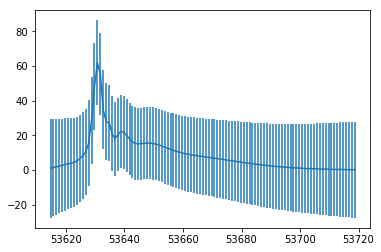

In [13]:
plt.figure()
plt.errorbar(x,yerr,y)
plt.show()

In [17]:
print len(dataset)
print dataset[0]['MJD']

800
[ 56769.042413  56770.042413  56771.042413  56772.042413  56773.042413
  56774.042413  56775.042413  56776.042413  56777.042413  56778.042413
  56779.042413  56780.042413  56781.042413  56782.042413  56783.042413
  56784.042413  56785.042413  56786.042413  56787.042413  56788.042413
  56789.042413  56790.042413  56791.042413  56792.042413  56793.042413
  56794.042413  56795.042413  56796.042413  56797.042413  56798.042413
  56799.042413  56800.042413  56801.042413  56802.042413  56803.042413
  56804.042413  56805.042413  56806.042413  56807.042413  56808.042413
  56809.042413  56810.042413  56811.042413  56812.042413  56813.042413
  56814.042413  56815.042413  56816.042413  56817.042413  56818.042413
  56819.042413  56820.042413  56821.042413  56822.042413  56823.042413
  56824.042413  56825.042413  56826.042413  56827.042413  56828.042413
  56829.042413  56830.042413  56831.042413  56832.042413  56833.042413
  56834.042413  56835.042413  56836.042413  56837.042413  56838.042413
  

In [ ]:

# convert the UBVRI strings into the relevent wavelengths in nm
flt_nm = []

for i in range(0,len(data['FLT'])):
    if data['FLT'][i] == 'U':
        flt_nm.append(365.0)
    if data['FLT'][i] == 'B':
        flt_nm.append(445.0)
    if data['FLT'][i] == 'V':
        flt_nm.append(551.0)
    if data['FLT'][i] == 'R':
        flt_nm.append(658.0)
    if data['FLT'][i] == 'I':
        flt_nm.append(806.0)
    if data['FLT'][i] == 'u':
        flt_nm.append(358.0)
    if data['FLT'][i] == 'g':
        flt_nm.append(475.4)
    if data['FLT'][i] == 'r':
        flt_nm.append(620.4)
    if data['FLT'][i] == 'i':
        flt_nm.append(769.8)
    if data['FLT'][i] == 'z':
        flt_nm.append(966.5)
        
x = np.array([data['MJD'],flt_nm]).T
mjd, flt = x.T
y = np.array(data['MAG'])
yerr = np.array(data['MAGERR'])

## k0
$ k_0(r) = \theta_0^2 \delta_{ij} $

To model the noise, we include a white noise kernel. The only hyper is the amplitude of the delta function, $\theta_0$

## k1
$ k_1(r) = \theta_1(\lambda)^2\delta_{\lambda\lambda'} \, \exp \left(-\frac{r^2}{2\,\theta_2} \right) $

To model the smooth decay in time, we use a squared exponential (SE) covariance term, 
with hypers controlling the amplitude $\theta_1$, which can arbitrarily vary with wavelength, and characteristic lengthscale $\theta_2$.

In [ ]:
maxy = np.array((max(y), x[np.argmax(y)][0], x[np.argmax(y)][1]))
miny = np.array((min(y), x[np.argmin(y)][0], x[np.argmin(y)][1]))
medy = np.array((np.median(y), x[np.argsort(y)[len(y)//2]][0],x[np.argsort(y)[len(y)//2]][1]) )

v1 = miny - maxy
v2 = medy - maxy

cp = np.cross(v1, v2)
a, b, c = cp

d = np.dot(cp, miny)
params = a,b,c,d

def mean_function(x):
    return (d-b*x[:,0]-c*x[:,1])/a

In [ ]:
''' setup Gaussian process with initialized parameters '''

# initial hyperparameters
theta0 = [1.0, 300.0, 10.0]
print 'The initial hypers are %s' % theta0

# noise
k0 = theta0[0] * kernels.Matern32Kernel(metric=theta0[1],ndim=2,dim=1)

# SE kernel for time, with amplitude that varies with wavelength
k1 = kernels.ExpSquaredKernel(metric=theta0[2]**2,ndim=2,dim=0)

# full kernel
kernel = k0 * k1

# set up gaussian process, setting the mean as the mean of the magnitude data
gp = george.GP(kernel, mean=mean_function)

# pre-compute the factorization of the covariance matrix
gp.compute(x, yerr)

# print the initial log likelihood and gradient, using the initial hypers
print 'The initial ln likelihood is %f' % gp.lnlikelihood(y)
print 'The initial gradient with respect to the hypers is %s' % gp.grad_lnlikelihood(y)

# predict (using initial hypers)
t0x, t0y = np.meshgrid(np.linspace(min(mjd), max(mjd), 50),np.linspace(min(flt), max(flt), 50))
t0 = np.array([t0x.ravel(), t0y.ravel()]).T
mu0, cov0 = gp.predict(y, t0)
std0 = np.sqrt(np.diag(cov0))


In [ ]:
# optimize hypers

# define the objective function (negative log-likelihood in this case)
def nll(p):
    # update the kernel parameters and compute the likelihood
    gp.kernel[:] = p
    ll = gp.lnlikelihood(y, quiet=True)

    # the scipy optimizer doesn't play well with infinities
    return -ll if np.isfinite(ll) else 1e25

# the gradient of the objective function.
def grad_nll(p):
    # update the kernel parameters and compute the likelihood
    gp.kernel[:] = p
    return -gp.grad_lnlikelihood(y, quiet=True)

# run the optimization routine
p0 = gp.kernel.vector # np.log(theta[0]**2, theta[1]**2, theta[2])

results = op.minimize(nll, p0, jac=grad_nll)

# update the kernel and print the final log-likelihood and gradient
gp.kernel[:] = results.x

# theta = theta_from_x(results)
theta = [np.sqrt(np.exp(results.x[0])),np.exp(results.x[1]),np.exp(results.x[2])]
print 'The optimized hypers are %s' % theta
print 'The optimized ln likelihood is %f' % gp.lnlikelihood(y)
print 'The optimized gradient with respect to the hypers is %s' % gp.grad_lnlikelihood(y)

# predict (using final hypers)
mu, cov = gp.predict(y, t0)
std = np.sqrt(np.diag(cov))

# predict slice
t0x_slice = np.linspace(min(mjd), max(mjd), 500)
t0y_slice_445 = 445.0 * np.ones_like(t0x_slice)
t0y_slice_551 = 551.0 * np.ones_like(t0x_slice)
t0y_slice_658 = 658.0 * np.ones_like(t0x_slice)
t0y_slice_806 = 806.0 * np.ones_like(t0x_slice)

t0_slice_445 = np.array([t0x_slice, t0y_slice_445]).T
t0_slice_551 = np.array([t0x_slice, t0y_slice_551]).T
t0_slice_658 = np.array([t0x_slice, t0y_slice_658]).T
t0_slice_806 = np.array([t0x_slice, t0y_slice_806]).T

mu_slice_445, cov_slice_445 = gp.predict(y, t0_slice_445)
std_slice_445 = np.sqrt(np.diag(cov_slice_445))

mu_slice_551, cov_slice_551 = gp.predict(y, t0_slice_551)
std_slice_551 = np.sqrt(np.diag(cov_slice_551))

mu_slice_658, cov_slice_658 = gp.predict(y, t0_slice_658)
std_slice_658 = np.sqrt(np.diag(cov_slice_658))

mu_slice_806, cov_slice_806 = gp.predict(y, t0_slice_806)
std_slice_806 = np.sqrt(np.diag(cov_slice_806))

In [ ]:
y_445=[]
yerr_445=[]
mjd_445=[]

y_551=[]
yerr_551=[]
mjd_551=[]

y_658=[]
yerr_658=[]
mjd_658=[]

y_806=[]
yerr_806=[]
mjd_806=[]

for i in range(0,len(flt)):
    if flt[i]==445.0:
        y_445.append(y[i])
        yerr_445.append(yerr[i])
        mjd_445.append(mjd[i])
    if flt[i]==551.0:
        y_551.append(y[i])
        yerr_551.append(yerr[i])
        mjd_551.append(mjd[i])
    if flt[i]==658.0:
        y_658.append(y[i])
        yerr_658.append(yerr[i])
        mjd_658.append(mjd[i])
    if flt[i]==806.0:
        y_806.append(y[i])
        yerr_806.append(yerr[i])
        mjd_806.append(mjd[i])

In [ ]:
'''3D plot'''

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim([-2,max(t0.T[0])-min(t0.T[0])+2])
ax.set_ylim([min(t0.T[1])-2,max(t0.T[1])+2])
ax.set_zlim([max(mu)+1.5,min(mu)-4.0])


ax.scatter(mjd_445-min(mjd_445), 445.0*np.ones_like(mjd_445), y_445, marker='o',c='#4D9DE0')
ax.scatter(mjd_551-min(mjd_551), 551.0*np.ones_like(mjd_551), y_551, marker='o',c='#E1BC29')
ax.scatter(mjd_658-min(mjd_658), 658.0*np.ones_like(mjd_658), y_658, marker='o',c='#E15554')
ax.scatter(mjd_806-min(mjd_806), 806.0*np.ones_like(mjd_806), y_806, marker='o',c='#7768AE')

ax.plot_trisurf(t0.T[0]-min(t0.T[0]), t0.T[1], mu,  alpha=0.1)

ax.text2D(0.05, 0.95, "SN 2000fa", transform=ax.transAxes)
ax.set_xlabel('Days')
ax.set_ylabel('Wavelength [nm]')
ax.set_zlabel('Luminosity [mag]')
plt.yticks(np.arange(500, 900, 100.0))

ax.view_init(elev=21., azim=-79.)

plt.show()
plt.savefig('surface_band_fit',dpi=300)

In [ ]:
'''Slice plots'''
matplotlib.rcParams.update({'font.size': 16})
# optimized GP fit
fig, ax = plt.subplots(1,1)
ax.set_xlim([-2,max(t0x_slice)-min(t0x_slice)+2])
ax.set_ylim([max(mu_slice_445+std_slice_445)+0.1,min(mu_slice_445-std_slice_445)-0.1])

# ax.errorbar(t0[0:500],y,yerr=yerr, lw=0.5, ls='None', label='data')
ax.plot(t0x_slice-min(mjd_445),mu_slice_445,label='B Band GP Fit',color="#326793", alpha=1)

ax.errorbar(mjd_445-min(mjd_445), y_445,yerr_445, c='#4D9DE0',fmt="o", capsize=0)
ax.fill_between(t0x_slice-min(mjd_445), mu_slice_445+std_slice_445, mu_slice_445-std_slice_445, facecolor='#56B3FF', alpha=0.1, label = '2$\sigma$ confidence')

# plt.title('%s Band GP Fit of %s' % (band,name))
plt.legend()
plt.xlabel('Days')
plt.ylabel('Luminosity [mag]')

# #save fig
# fig_ext = 'fig/photometry_'+name+'_'+band+'band'
plt.savefig('b_band_fit',dpi=300)

plt.show()


In [ ]:
'''Slice plots'''
# optimized GP fit
fig, ax = plt.subplots(1,1)
ax.set_xlim([-2,max(t0x_slice)-min(t0x_slice)+2])
ax.set_ylim([max(mu_slice_551+std_slice_551)+0.1,min(mu_slice_551-std_slice_551)-0.1])

# ax.errorbar(t0[0:500],y,yerr=yerr, lw=0.5, ls='None', label='data')
ax.plot(t0x_slice-min(mjd_551),mu_slice_551,label='V Band GP Fit',color="#937B1A", alpha=1)

ax.errorbar(mjd_551-min(mjd_551), y_551,yerr_551, c='#E1BC29',fmt="o", capsize=0)
ax.fill_between(t0x_slice-min(mjd_551), mu_slice_551+std_slice_551, mu_slice_551-std_slice_551, facecolor='#FFD52D', alpha=0.1, label = '2$\sigma$ confidence')

# plt.title('%s Band GP Fit of %s' % (band,name))
plt.legend()
plt.xlabel('Days')
plt.ylabel('Luminosity [mag]')

# #save fig
# fig_ext = 'fig/photometry_'+name+'_'+band+'band'
plt.savefig('v_band_fit',dpi=300)

plt.show()

In [ ]:
'''Slice plots'''
# optimized GP fit
fig, ax = plt.subplots(1,1)
ax.set_xlim([-2,max(t0x_slice)-min(t0x_slice)+2])
ax.set_ylim([max(mu_slice_658+std_slice_658)+0.1,min(mu_slice_658-std_slice_658)-0.1])

# ax.errorbar(t0[0:500],y,yerr=yerr, lw=0.5, ls='None', label='data')
ax.plot(t0x_slice-min(mjd_658),mu_slice_658,label='R Band GP Fit',color="#933636", alpha=1)

ax.errorbar(mjd_658-min(mjd_658), y_658,yerr_658, c='#E15554',fmt="o", capsize=0)
ax.fill_between(t0x_slice-min(mjd_658), mu_slice_658+std_slice_658, mu_slice_658-std_slice_658, facecolor='#FF5E5E', alpha=0.1, label = '2$\sigma$ confidence')

# plt.title('%s Band GP Fit of %s' % (band,name))
plt.legend()
plt.xlabel('Days')
plt.ylabel('Luminosity [mag]')

# #save fig
# fig_ext = 'fig/photometry_'+name+'_'+band+'band'
plt.savefig('r_band_fit',dpi=300)

plt.show()

In [ ]:
'''Slice plots'''
# optimized GP fit
fig, ax = plt.subplots(1,1)
ax.set_xlim([-2,max(t0x_slice)-min(t0x_slice)+2])
ax.set_ylim([max(mu_slice_806+std_slice_806)+0.1,min(mu_slice_806-std_slice_806)-0.1])

# ax.errorbar(t0[0:500],y,yerr=yerr, lw=0.5, ls='None', label='data')
ax.plot(t0x_slice-min(mjd_806),mu_slice_806,label='I Band GP Fit',color="#423A60", alpha=1)

ax.errorbar(mjd_806-min(mjd_806), y_806,yerr_806, c='#7768AE',fmt="o", capsize=0)
ax.fill_between(t0x_slice-min(mjd_806), mu_slice_806+std_slice_806, mu_slice_806-std_slice_806, facecolor='#AF99FF', alpha=0.1, label = '2$\sigma$ confidence')

# plt.title('%s Band GP Fit of %s' % (band,name))
plt.legend()
plt.xlabel('Days')
plt.ylabel('Luminosity [mag]')

# #save fig
# fig_ext = 'fig/photometry_'+name+'_'+band+'band'
plt.savefig('i_band_fit',dpi=300)

plt.show()